# Chapter6 게이트가 추가된 RNN

In [1]:
from IPython.display import Image
import numpy as np

## 6.1 RNN의 문제점

### 6.1.1 RNN 복습

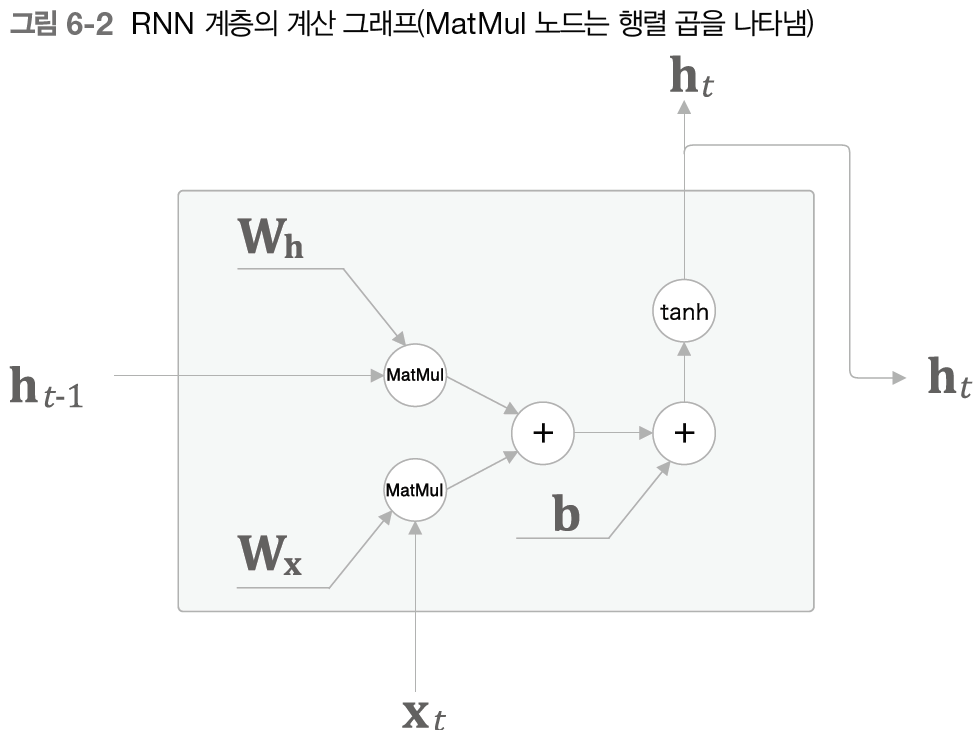

In [3]:
Image("image/fig 6-2.png")

### 6.1.2 기울기 소실 또는 기울기 폭발

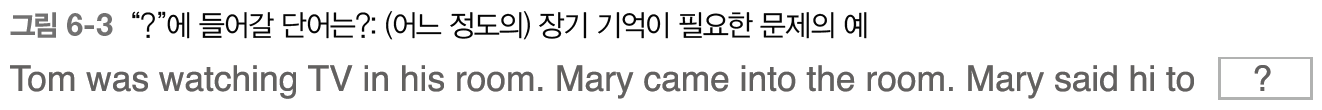

In [5]:
Image("image/fig 6-3.png")

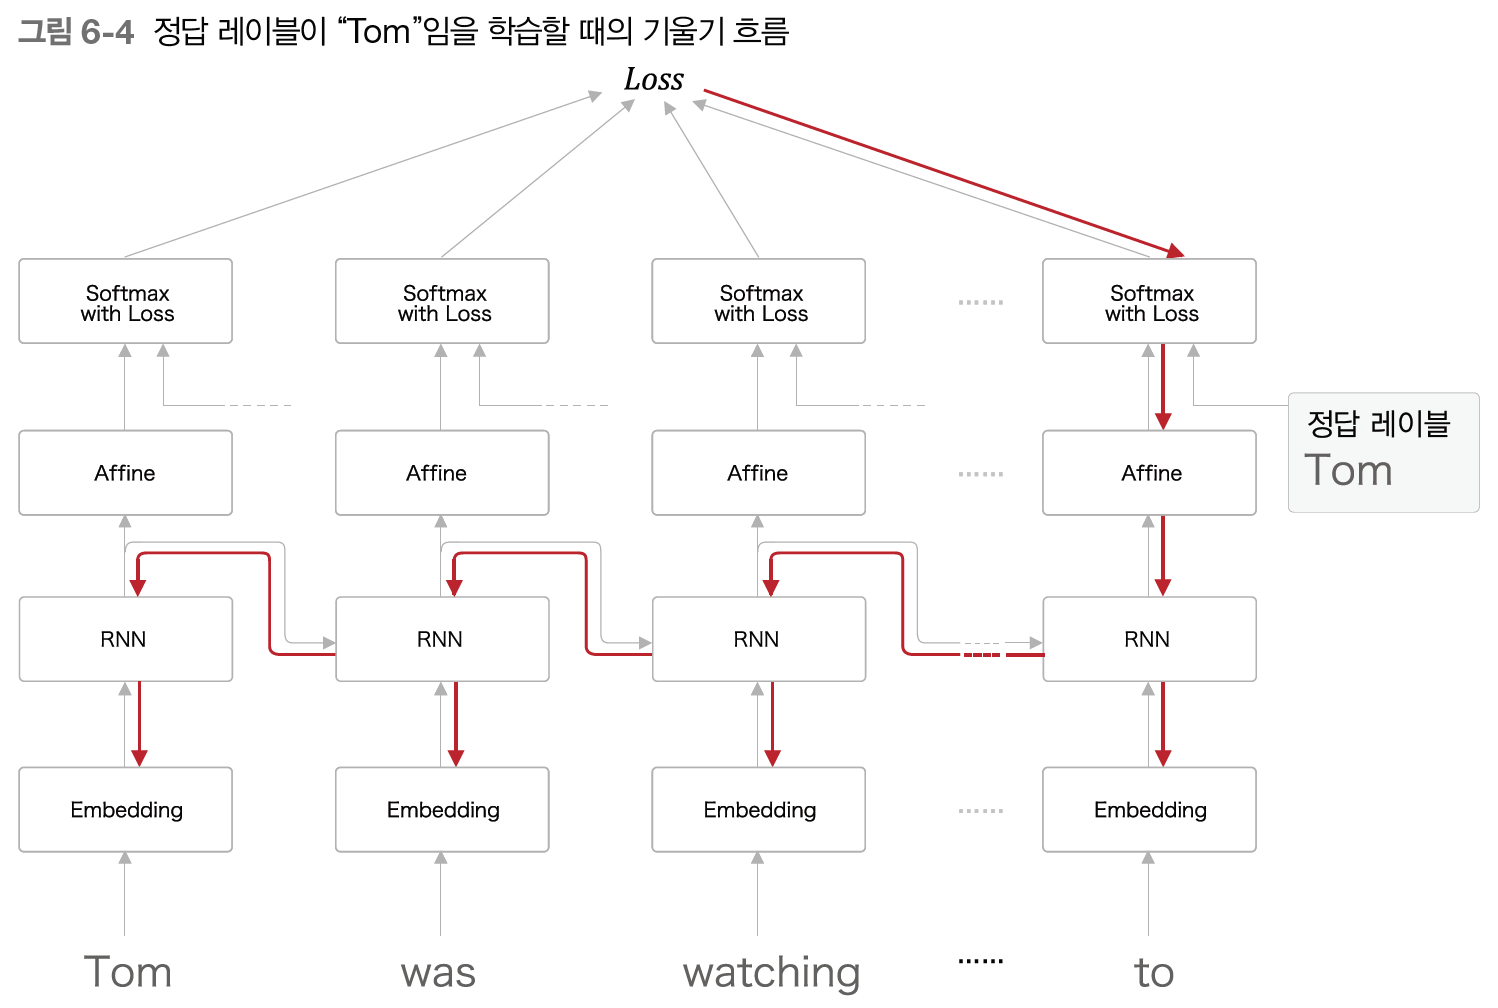

In [4]:
Image("image/fig 6-4.png")

현재의 RNN 계층에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나 커질 수 있음 -> 장기의존 관계를 학습할 수 없게 됨(매개변수가 갱신되기 힘들기 때문)

### 6.1.3 기울기 소실과 기울기 폭발의 원인

- y=tanh(x)를 미분하다보면 그 값은 계속 작아진다 -> **기울기 소실**
- 행렬 Wh를 T번 반복해서 곱하기 때문에 MatMul 노드의 역전파 기울기는 지수적으로 커지거나 작아진다 -> **기울기 폭발**, **기울기 소실**

### 6.1.4 기울기 폭발 대책

**기울기 클리핑** -> threshold를 문턱값으로 설정하고, 기울기의 L2 노름이 이 문턱값을 초과하면 기울기를 수정한다!

## 6.2 기울기 소실과 LSTM

### 6.2.1 LSTM의 인터페이스

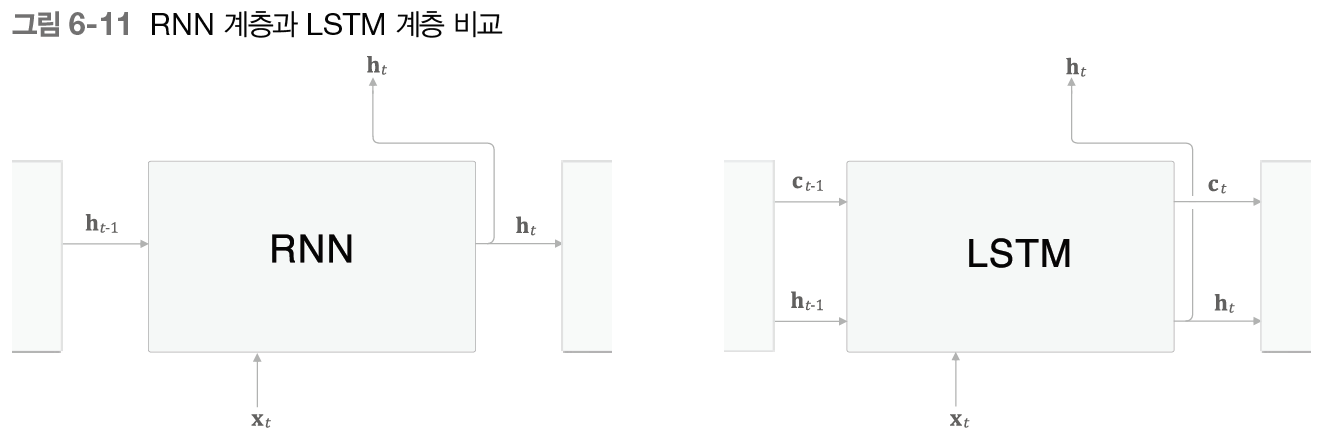

In [7]:
Image("image/fig 6-11.png")

- LSTM 계층의 인터페이스에는 c(기억 셀)라는 경로가 있음
- **c(기억 셀)**는 데이터를 LSTM 계층 내에서만 주고받음 (다른 계층으로 출력 X)
- LSTM의 **은닉상태 h**는 다른 계층으로 출력 O

### 6.2.2 LSTM 계층 조립하기

c(t)에는 과거로부터 시각 t까지에 필요한 모든 정보가 저장돼 있다고 가정

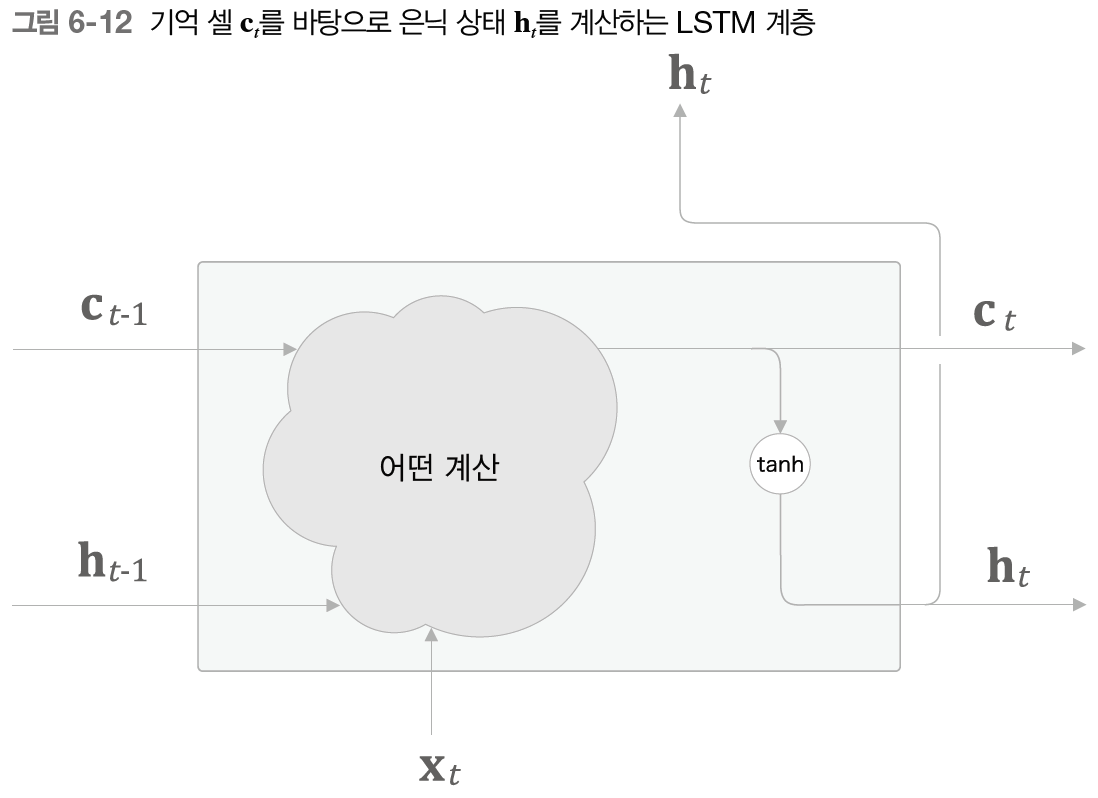

In [8]:
Image("image/fig 6-12.png")

- 갱신된 c(t)를 활용해 은닉상태 h(t)를 계산한다는 것이 핵심!
- h(t) = **tanh(** c(t) **)**

#### +) 게이트
- 데이터의 흐름을 제어
- 게이트의 열림 상태는 0~1사이의 실수로 나타남 -> 시그모이드 함수 사용
- 게이트를 얼마나 열지는 자동으로 학습

### 6.2.3 output 게이트

output 게이트의 열림상태(얼마나 흘려보낼까)는 x(t)와 h(t-1)로부터 구한다!

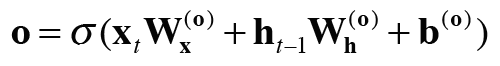

In [9]:
Image("image/e 6-1.png")

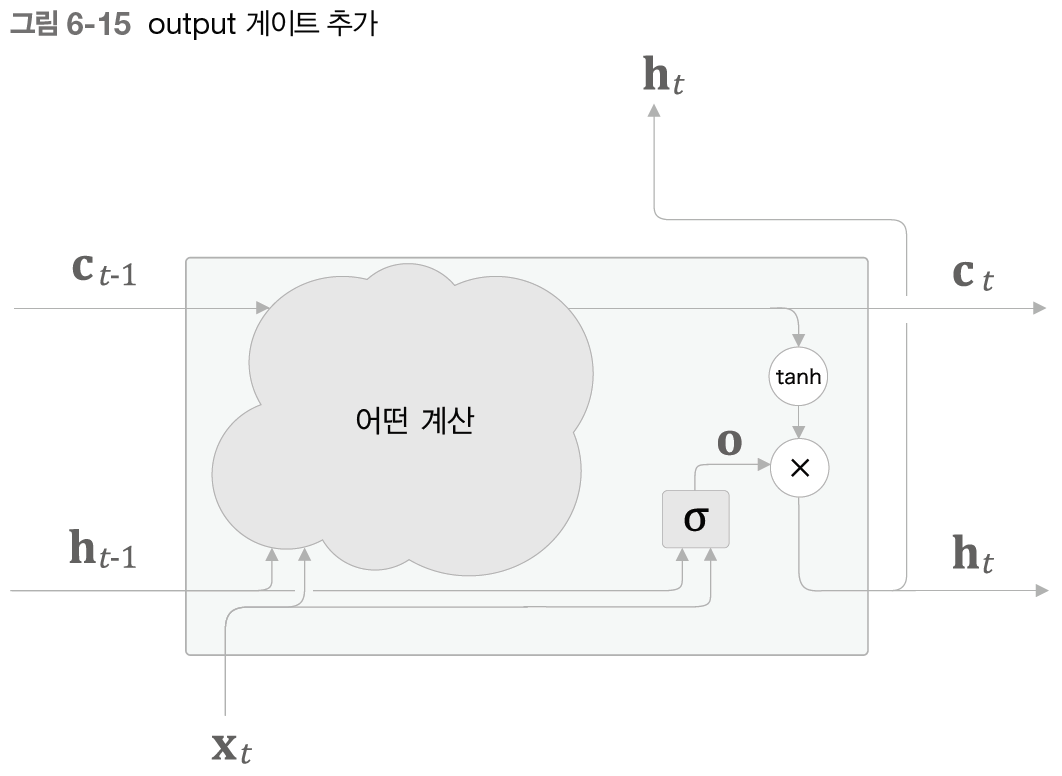

In [10]:
Image("image/fig 6-15.png")

이때, O와 tanh(c(t))의 곱은 아다마르 곱으로 수행됨

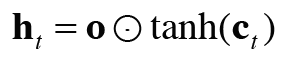

In [12]:
Image("image/e 6-2.png")

### 6.2.4 forget 게이트

기억 셀에 '무엇을 잊을지'를 명확하게 지시할 필요가 있음 

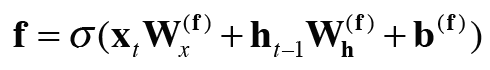

In [14]:
Image("image/e 6-3.png")

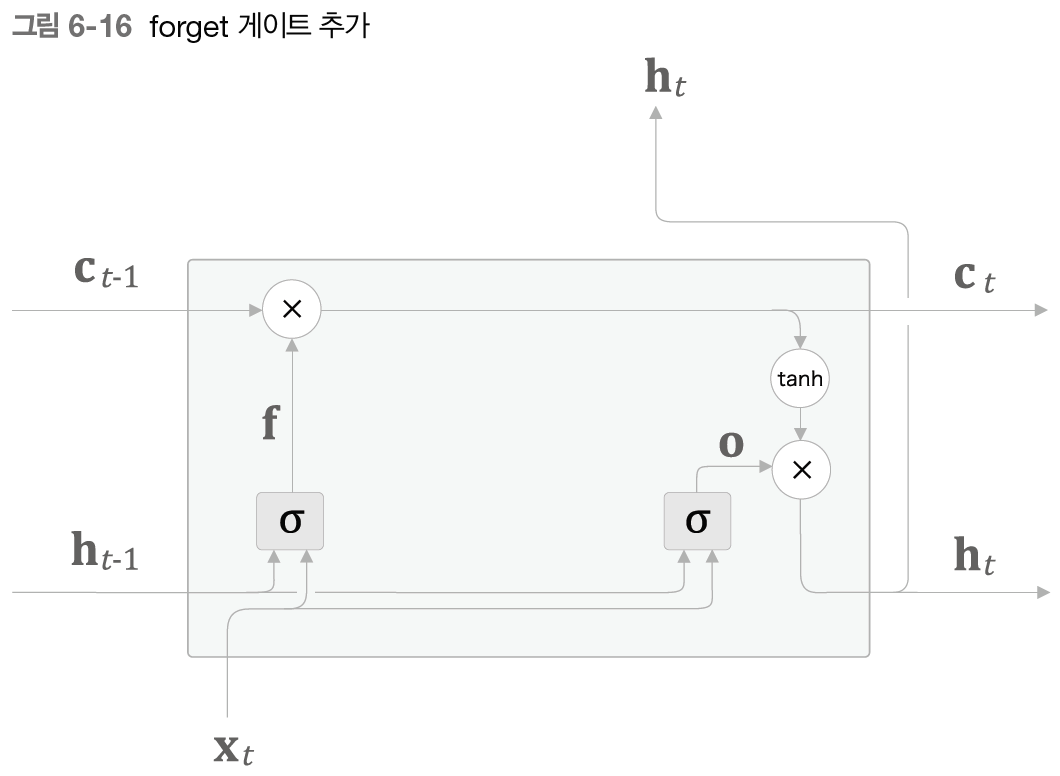

In [13]:
Image("image/fig 6-16.png")

### 6.2.5 새로운 기억 셀

앞에서 기억이 삭제되었으므로 새로 기억해야 할 정보를 기억셀에 추가해야 함!

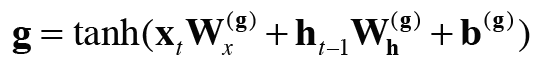

In [17]:
Image("image/e 6-4.png")

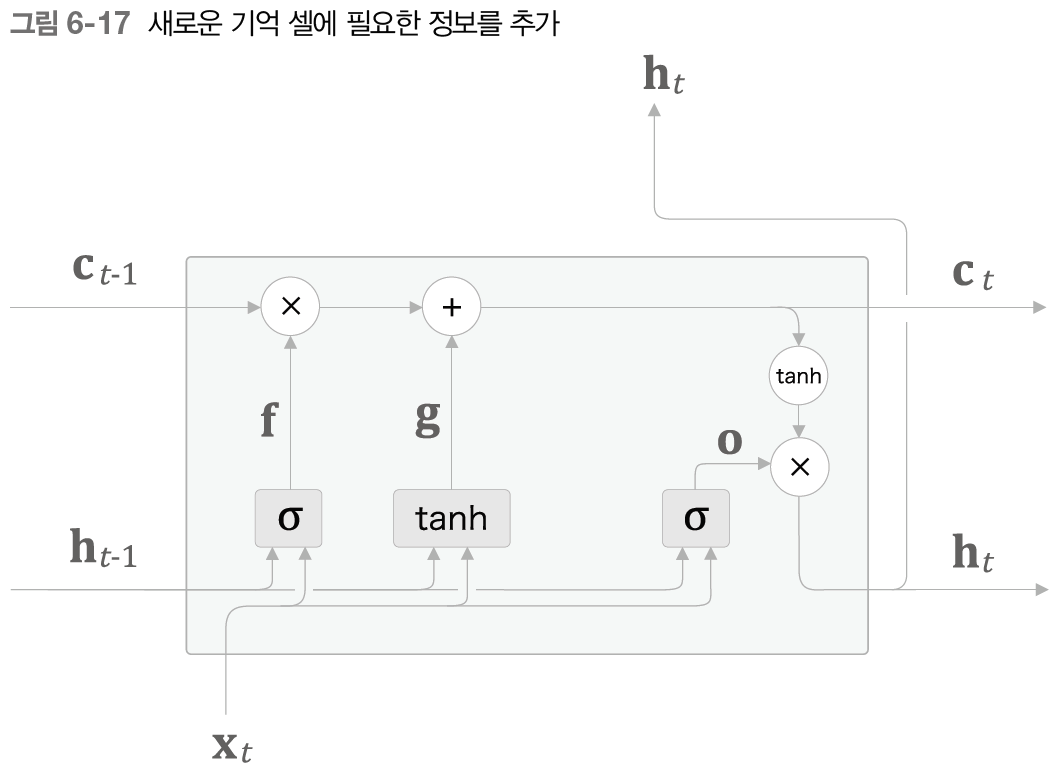

In [15]:
Image("image/fig 6-17.png")

### 6.2.6 input 게이트

각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지 판단

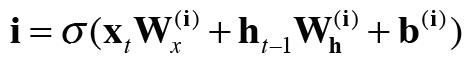

In [18]:
Image("image/e 6-5.png")

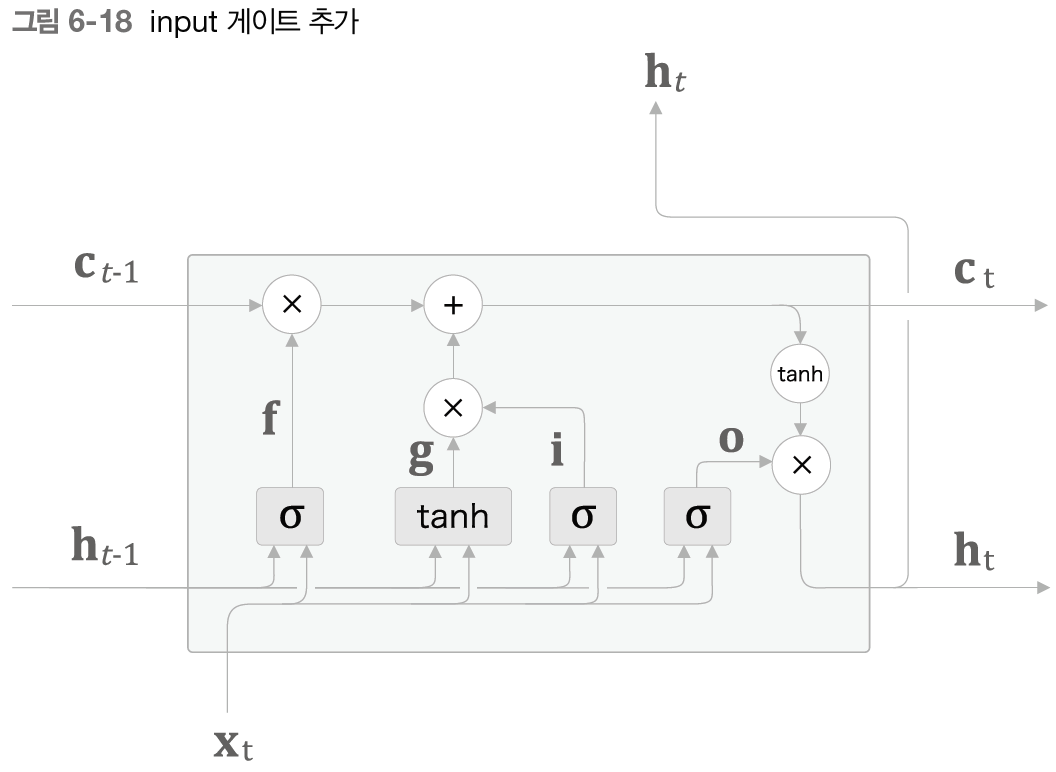

In [19]:
Image("image/fig 6-18.png")

## 6.3 LSTM 구현

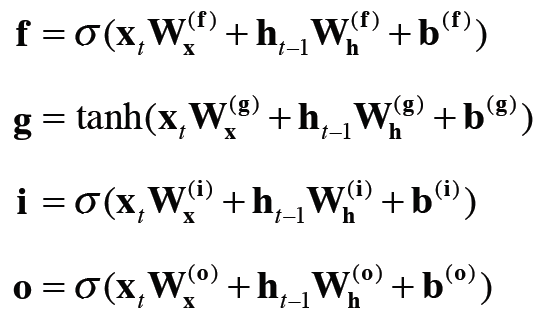

In [20]:
Image("image/e 6-6.png")

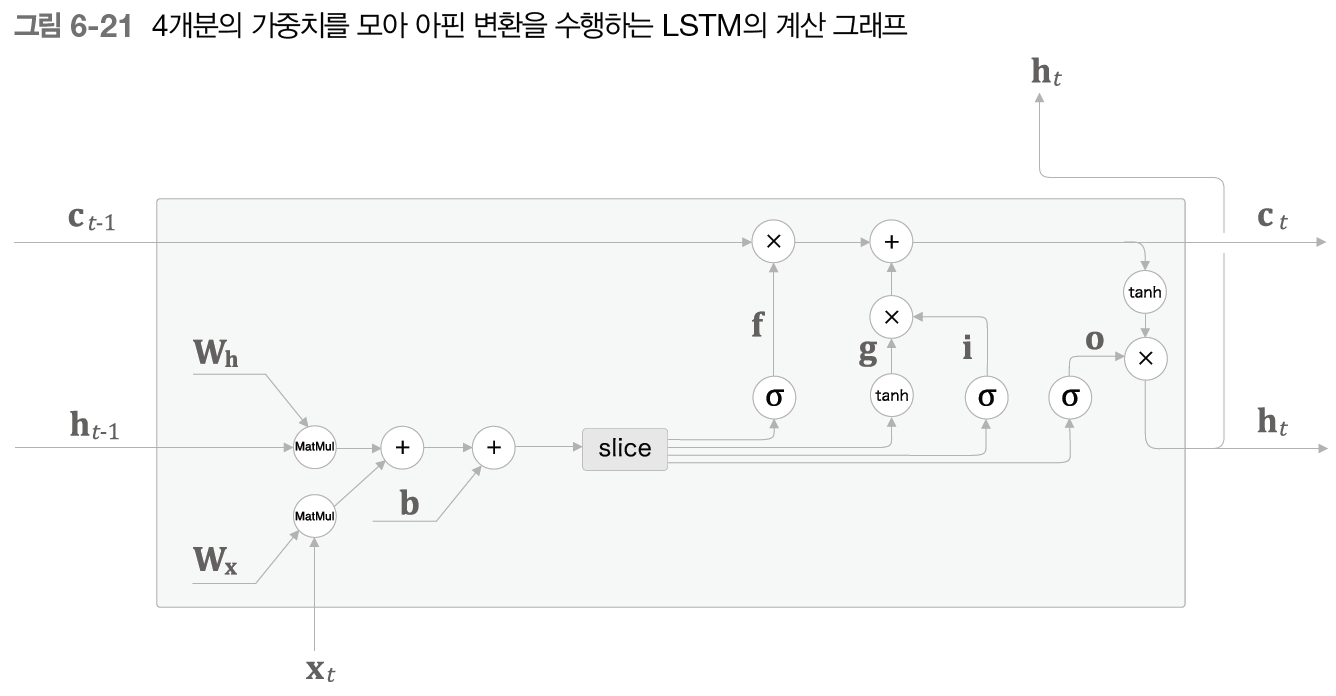

In [22]:
Image("image/fig 6-21.png")

In [23]:
class LSTM:
    
    
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### 6.3.1 Time LSTM 구현

In [24]:
class TimeLSTM:
    
    
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.5 RNNLM 추가 개선

- LSTM 계층 깊게 쌓기
- 드롭아웃을 이용해 과적합 억제하기 -> 무작위로 뉴런을 선택해서 선택한 뉴런 무시
- 가중치 공유하기

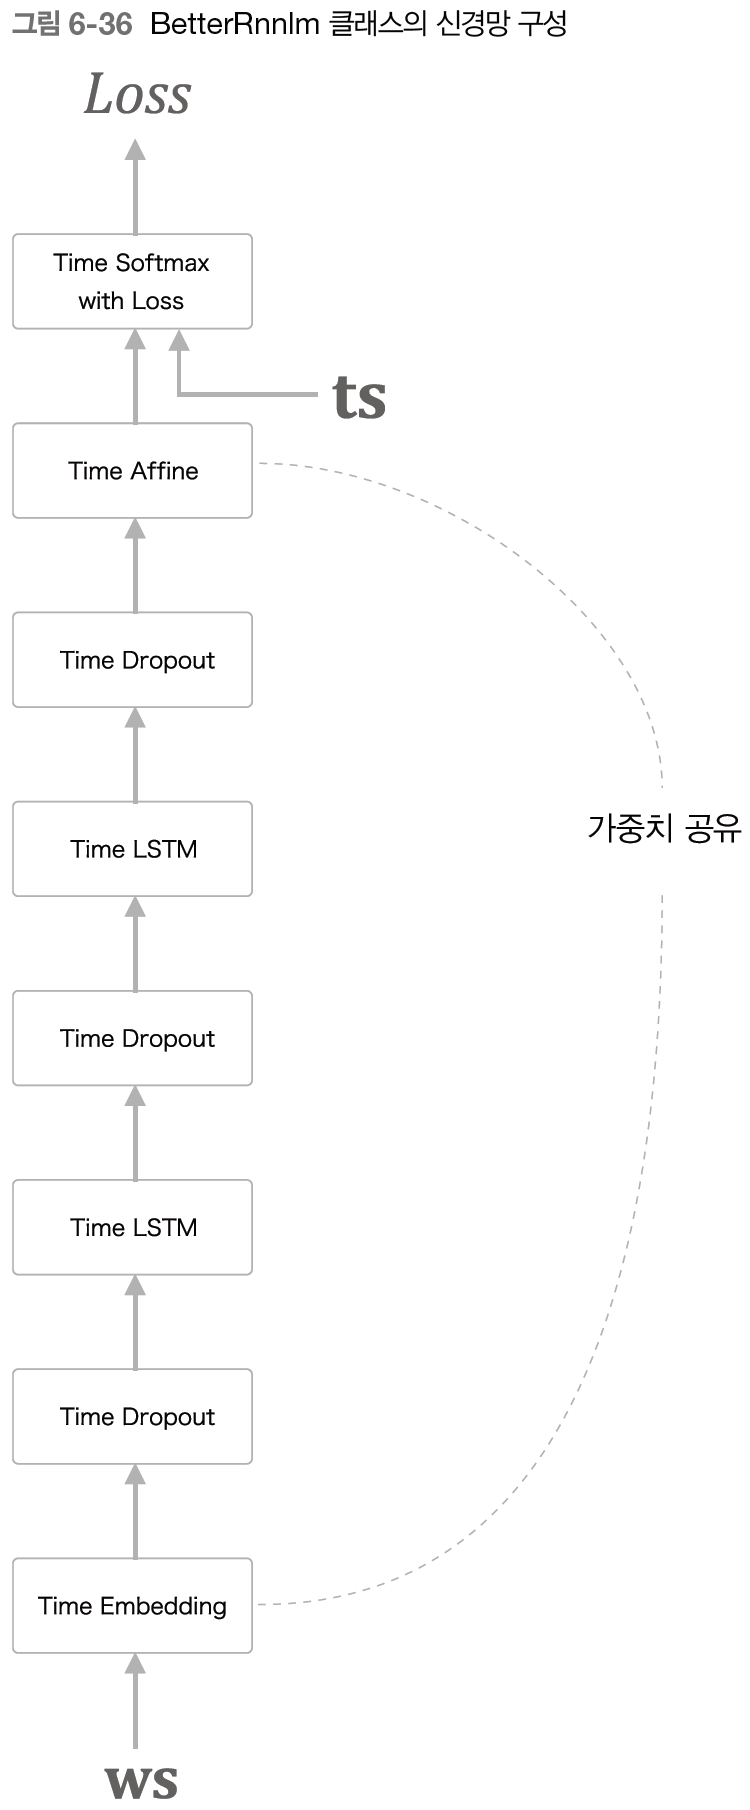

In [25]:
Image("image/fig 6-36.png")

In [29]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):

    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
import sys
sys.path.append('..')
from common import config
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
import ptb



# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)